# Project Introduction

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
# load the data
# rating
ratings = pd.read_csv('data/ratings.csv', usecols=['userId', 'movieId', 'rating'])
# movie
movies = pd.read_csv('data/movies.csv', usecols=['movieId', 'title', 'genres'])
# tag
tags = pd.read_csv('data/tags.csv', usecols=['userId', 'movieId', 'tag'])
print(ratings.head())
print(movies.head())
print(tags.head())

## Exploratory Analysis

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

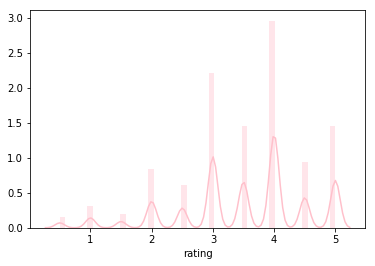

In [33]:
# Rating 
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean())
sns.distplot(ratings['rating'].fillna(ratings['rating'].mean()), color ='pink') #Fill missing value with column mean
ratings['rating'].describe()

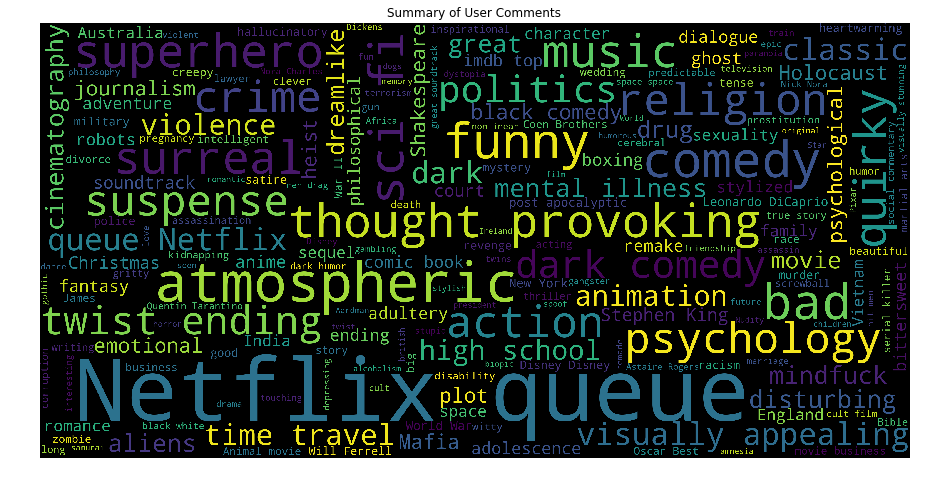

In [34]:
# create tag wordcloud
tags['tag'] = tags['tag'].fillna("").astype('str')
tag_corpus = ' '.join(tags['tag'])
tag_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(tag_corpus)
# plot the word cloud
plt.figure(figsize=(16,8))
plt.imshow(tag_wordcloud)
plt.axis('off')
plt.title('Summary of User Comments')
plt.show()

## Content-Based Section  
#### Using Genres to make the recommendation 

In [35]:
# Grouping by similar tags
tags['tag'] = tags['tag'].str.split('|')
tags['tag'] = tags['tag'].fillna("").astype('str')

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(tags['tag'])
tfidf_matrix.shape

(3683, 2421)

In [37]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [38]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie tags
def tag_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [39]:
# Recommendations on movie
tag_recommendations('Toy Story (1995)').head(20)

63                                       Fair Game (1995)
68                                       Screamers (1995)
206                                       Hideaway (1995)
219                                Jerky Boys, The (1995)
226                             Little Princess, A (1995)
239                         Miracle on 34th Street (1994)
254     Léon: The Professional (a.k.a. The Professiona...
305                                    Bitter Moon (1992)
391                                    With Honors (1994)
393                                   Widows' Peak (1994)
420                                    Killing Zoe (1994)
495     Ciao, Professore! (Io speriamo che me la cavo)...
557                World of Apu, The (Apur Sansar) (1959)
647                                        Foxfire (1996)
909                                 Apocalypse Now (1979)
2563                                    Death Wish (1974)
2736                         For the Love of Benji (1977)
2817          

## User-Based Section  
#### Use user rating for the recommendations

In [40]:
# Missing movie ID is given 0 
ratings['userId'] = ratings['userId'].fillna(0)
ratings['movieId'] = ratings['movieId'].fillna(0)
# Replace NaN values in rating column with average of all values
ratings['rating'] = ratings['rating'].fillna(ratings['rating'].mean()) #replace NAN with mean

In [47]:
small_data = ratings.sample(frac=0.01)

In [48]:
from sklearn import model_selection
train_data, test_data = model_selection.train_test_split(small_data, test_size=0.2)
train_data_matrix = train_data.as_matrix(columns = ['userId', 'movieId', 'rating'])
test_data_matrix = test_data.as_matrix(columns = ['userId', 'movieId', 'rating'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [49]:
from sklearn.metrics.pairwise import pairwise_distances
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1.         0.99469662 0.99495317 0.98593275]
 [0.99469662 1.         0.9793563  0.96351294]
 [0.99495317 0.9793563  1.         0.99772805]
 [0.98593275 0.96351294 0.99772805 1.        ]]


In [50]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[ 1.          0.06067906 -0.06807005]
 [ 0.06067906  1.          0.03319855]
 [-0.06807005  0.03319855  1.        ]]


In [51]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [53]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 23314.595385466295
Item-based CF RMSE: 27356.496528061387


In [54]:
# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 17683.581480786797
Item-based CF RMSE: 2663.0574478298345
